In [8]:
%load_ext autoreload
%autoreload 2

import os
os.chdir('/home/haman/layers56/OptLSV1M')

import numpy
import matplotlib as mpl
import matplotlib.pyplot as plt

from utils import *

mpl.rcParams['mathtext.default'] = 'regular'
cmap = mpl.colormaps['plasma']

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [9]:
sheet_names = ['V1_Exc_L4', 'V1_Inh_L4', 'V1_Exc_L2/3', 'V1_Inh_L2/3']
sheet_names_formatted = {
    'V1_Exc_L4': "Layer 4 Exc.",
    'V1_Inh_L4': "Layer 4 Inh.",
    'V1_Exc_L2/3': "Layer 2/3 Exc.",
    'V1_Inh_L2/3': "Layer 2/3 Inh.",
}

In [10]:
class CellRate():

    def __init__(self, prefered_orientation=None):
        self.prefered_orientation = prefered_orientation
        self.gratings_rates = []
        self.gratings_orientations = []
        self.gratings_radius = []
        self.spont_rate = []

    @property
    def grating_orientation_relative(self):
        _rel_orient = []
        for go in self.gratings_orientations:
            _diff = go - self.prefered_orientation
            if _diff < - (numpy.pi / 2):
                _diff += numpy.pi
            if _diff > numpy.pi / 2:
                _diff -= numpy.pi
            _rel_orient.append(_diff)
        return _rel_orient

    def get_mean_rate_for_radius(self, target_radius):
        if not cell.spont_rate:
            return numpy.nan

        _rates = []
        for radius, rate in zip(self.gratings_radius, self.gratings_rates):
            if numpy.isclose(radius, target_radius, atol=0.05):
                _rates.append(rate)# / self.spont_rate)

        return numpy.nanmean(_rates)

# Spontaneous

In [11]:
run_id = "20250206-162554"
for sheet_name in sheet_names:
    datastore_to_pickle(run_id, sheet_name)
data_store = get_data_stores(run_id)[0]

Did not pickle 20250206-162554 because it has already been pickled
Did not pickle 20250206-162554 because it has already been pickled
Did not pickle 20250206-162554 because it has already been pickled
Did not pickle 20250206-162554 because it has already been pickled
Reading folder ./20250206-162554[param-optim.defaults]CombinationParamSearch{36}/SelfSustainedPushPull_ParameterSearch_____density_frac:0.09181069664671171_K:2072.8904115133


In [12]:
# Get the spont activity
data_per_sheet = {}
for sheet_name in sheet_names:
    data = read_pickled_datastore(run_id, sheet_name)
    data_per_sheet[sheet_name] = next(seg for seg in data if 'orientation' not in seg.annotation)

In [15]:
!pwd

/home/haman/layers56/OptLSV1M


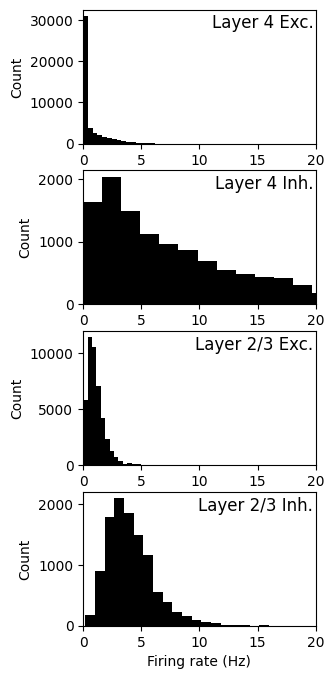

In [16]:
# SANITY TEST:
tolerance = 0.1 # rad
fig, axs = plt.subplots(4, figsize=(3, 8))
for idx_ax, sheet_name in enumerate(sheet_names):
    spont_seg = data_per_sheet[sheet_name]
    axs[idx_ax].hist([1000. * len(st) / spont_seg.duration for st in spont_seg.spiketrains], color="black", bins=20)
    axs[idx_ax].set_ylabel("Count")
    axs[idx_ax].set_xlim(0, 20)
    axs[idx_ax].set_title(sheet_names_formatted[sheet_name], x=0.99, y=0.80, ha='right') 
axs[-1].set_xlabel("Firing rate (Hz)")

plt.savefig(f"./figures/hist_firing_rate_{run_id}.png", dpi=100, bbox_inches="tight", transparent=True)
plt.show()

/home/haman/virt_env/layers56new/lib/python3.12/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/haman/virt_env/layers56new/lib/python3.12/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/haman/virt_env/layers56new/lib/python3.12/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/haman/virt_env/layers56new/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/haman/virt_env/layers56new/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/haman/virt_env/layers56new/lib/python3.12/si

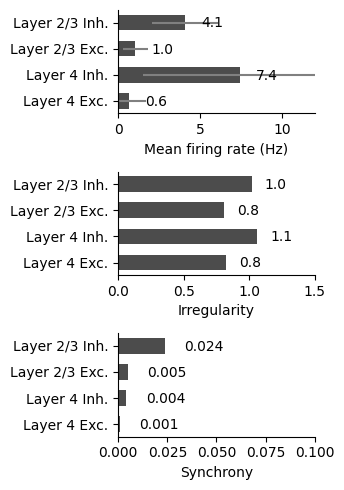

In [17]:
fig, axs = plt.subplots(3, figsize=(3.5, 5))

# Plot the spont activity rate/CC/CV with error bar
for ypos, (sheet_name, seg) in enumerate(data_per_sheet.items()):
    mean_rate = float(seg.mean_rate)
    std_rate = float(numpy.std([1000. * len(s) / seg.duration for s in seg.spiketrains]))
    axs[0].barh(ypos, mean_rate, height=0.6, color="black", alpha=0.7)
    axs[0].errorbar(mean_rate, ypos, xerr=float(std_rate), color="gray")
    axs[0].text(mean_rate + 1, ypos - 0.19, f"{mean_rate:.1f}")

axs[0].set_xlim(0, 12)
axs[0].set_xlabel("Mean firing rate (Hz)")

# Plot the Irregularity (CV)
for ypos, (sheet_name, seg) in enumerate(data_per_sheet.items()):
    isis = [numpy.diff(st) for st in seg.spiketrains]
    idxs = numpy.array([len(isi) for isi in isis]) > 5
    cvs = numpy.array([numpy.std(isi) / numpy.mean(isi) for isi in isis])[idxs]
    cv_mean = float(numpy.mean(cvs))
    cv_std = float(numpy.std(cvs))
    axs[1].barh(ypos, cv_mean, height=0.6, color="black", alpha=0.7)
    axs[1].errorbar(mean_rate, ypos, xerr=cv_std, color="gray")
    axs[1].text(cv_mean + 0.1, ypos - 0.19, f"{cv_mean:.1f}")

axs[1].set_xlim(0, 1.5)
axs[1].set_xlabel("Irregularity")

# Plot the Synchrony (CV)
for ypos, (sheet_name, seg) in enumerate(data_per_sheet.items()):
    spiketrains = seg.spiketrains[:2000]
    isis = [numpy.diff(st) for st in spiketrains]
    idxs = numpy.array([len(isi) for isi in isis]) > 5
    num_bins = int(seg.duration / 10.)
    r = (float(round(seg.t_start, 5)), float(round(seg.t_stop, 5)))
    psths = [numpy.histogram(x, bins=num_bins, range=r)[0] for x in spiketrains]
    corrs = numpy.nan_to_num(numpy.corrcoef(numpy.squeeze(psths)))
    ccs = corrs[idxs, :][:, idxs][numpy.triu_indices(sum(idxs == True), 1)]
    cc_mean = float(numpy.mean(ccs))
    cc_std = float(numpy.std(ccs))
    axs[2].barh(ypos, cc_mean, height=0.6, color="black", alpha=0.7)
    axs[2].errorbar(mean_rate, ypos, xerr=cc_std, color="gray")
    axs[2].text(cc_mean + 0.01, ypos - 0.19, f"{cc_mean:.3f}")

axs[2].set_xlim(0, 0.1)
axs[2].set_xlabel("Synchrony")

for ax in axs:
    ax.set_yticks(list(range(len(data_per_sheet))))
    ax.set_yticklabels([sheet_names_formatted[n] for n in data_per_sheet.keys()])
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

plt.tight_layout()

plt.savefig(f"./figures/spontaneous_activity_{run_id}.png", dpi=100, bbox_inches="tight", transparent=True)
plt.show()

# Orientation tuning

In [8]:
run_id = "20250206-162554"
for sheet_name in sheet_names:
    datastore_to_pickle(run_id, sheet_name)

Did not pickle 20250121-132347 because it has already been pickled
Did not pickle 20250121-132347 because it has already been pickled
Did not pickle 20250121-132347 because it has already been pickled
Did not pickle 20250121-132347 because it has already been pickled


In [18]:
# Get the OT activity
data_per_sheet = {}
data_spont_per_sheet = {}
data_store = get_data_stores(run_id)[0]
for sheet_name in sheet_names:
    data = read_pickled_datastore(run_id, sheet_name)
    data_per_sheet[sheet_name] = [seg for seg in data if 'orientation' in seg.annotation]
    data_spont_per_sheet[sheet_name] = next(seg for seg in data if 'orientation' not in seg.annotation)

Reading folder ./20250206-162554[param-optim.defaults]CombinationParamSearch{36}/SelfSustainedPushPull_ParameterSearch_____density_frac:0.09181069664671171_K:2072.8904115133


NeuronAnnotationsToPerNeuronValues analysis took: 0.7325739860534668seconds


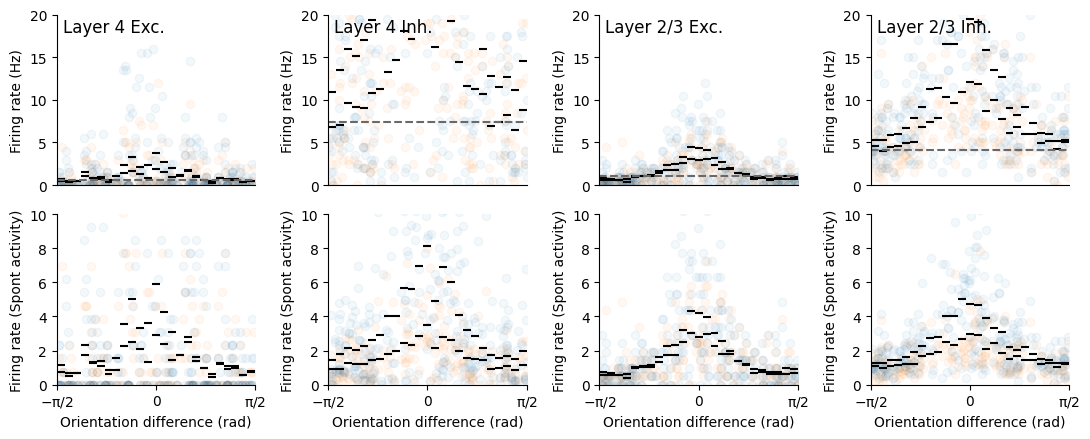

In [19]:
from scipy import stats

fig, axs = plt.subplots(2, 4, figsize=(11, 4.5))

for idx_plot, sheet_name in enumerate(sheet_names):

    orientations_cells = get_orientation_preference(data_store, sheet_name).values

    for contrast in [10, 100]:

        cells = [CellRate(oc) for oc in orientations_cells]

        # Get the gratings fire rate
        for seg in data_per_sheet[sheet_name]:
            if seg.annotation["contrast"] == contrast:
                for idx, st in enumerate(seg.spiketrains):
                    cells[idx].gratings_rates.append(1000. * len(st) / seg.duration)
                    cells[idx].gratings_orientations.append(seg.annotation["orientation"])

        # Binning
        x = []
        y = []
        for cell in cells[:400]:
            x += cell.grating_orientation_relative
            y += cell.gratings_rates
        bin_means, bin_edges, binnumber = stats.binned_statistic(x, y, statistic='mean', bins=25, range=(-numpy.pi / 2, numpy.pi / 2))
        bin_width = (bin_edges[1] - bin_edges[0])
        bin_centers = bin_edges[1:] - bin_width/2

        color = "C0" if contrast == 100 else "C1"
        for cell in cells[:100]:
            axs[0][idx_plot].scatter(cell.grating_orientation_relative, cell.gratings_rates, color=color, alpha=0.05)
            axs[1][idx_plot].scatter(cell.grating_orientation_relative, cell.gratings_rates / data_spont_per_sheet[sheet_name].mean_rate, color=color, alpha=0.05)

        axs[0][idx_plot].hlines(bin_means, bin_edges[:-1], bin_edges[1:], colors='black', lw=1.5)
        axs[1][idx_plot].hlines(bin_means / data_spont_per_sheet[sheet_name].mean_rate, bin_edges[:-1], bin_edges[1:], colors='black', lw=1.5)
        axs[0][idx_plot].set_title(sheet_names_formatted[sheet_name], x=0.03, y=0.85, ha='left') 

    # Spontaneous rate
    axs[0][idx_plot].axhline(data_spont_per_sheet[sheet_name].mean_rate, color='dimgray', lw=1.5, ls='--')

for ax in axs[0]:
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_xlim(-numpy.pi / 2, numpy.pi / 2)
    ax.set_ylim(0, 20)
    ax.set_ylabel("Firing rate (Hz)")
    ax.set_xticks([])
    ax.set_xticklabels([])

for ax in axs[1]:
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_xlim(-numpy.pi / 2, numpy.pi / 2)
    ax.set_ylim(0, 10)
    ax.set_ylabel("Firing rate (Spont activity)")
    ax.set_xlabel("Orientation difference (rad)")
    ax.set_xticks([-numpy.pi / 2, 0, numpy.pi / 2])
    ax.set_xticklabels([r'$-\pi /2$', '0', r'$\pi /2$'])

plt.tight_layout()

plt.savefig(f"./figures/orientation_tuning_{run_id}.png", dpi=100, bbox_inches="tight", transparent=True)
plt.show()

# Size tuning

In [20]:
run_id = "20250206-162554"
tolerance = 0.1  # rad
contrast = 100

for sheet_name in ['V1_Exc_L4', 'V1_Inh_L4', 'V1_Exc_L2/3', 'V1_Inh_L2/3']:
    datastore_to_pickle(run_id, sheet_name)

Did not pickle 20250206-162554 because it has already been pickled
Did not pickle 20250206-162554 because it has already been pickled
Did not pickle 20250206-162554 because it has already been pickled
Did not pickle 20250206-162554 because it has already been pickled


In [21]:
# Get the ST activity
data_per_sheet = {}
data_spont_per_sheet = {}
data_store = get_data_stores(run_id)[0]
for sheet_name in sheet_names:
    data = read_pickled_datastore(run_id, sheet_name)
    data_per_sheet[sheet_name] = [seg for seg in data if 'orientation' in seg.annotation]
    data_spont_per_sheet[sheet_name] = next(seg for seg in data if 'orientation' not in seg.annotation)

Reading folder ./20250206-162554[param-optim.defaults]CombinationParamSearch{36}/SelfSustainedPushPull_ParameterSearch_____density_frac:0.09181069664671171_K:2072.8904115133


In [ ]:
# Size tuning based on fitting with sum of gaussians
from scipy.optimize import differential_evolution
from scipy.special import erf


def sum_of_gaussian(p, x):
        return (p[0] * erf(x / p[1])**2
                - p[2] * erf(x / (p[1] + p[3]))**2
                + p[4] * erf(x / (p[1] + p[3] + p[5]))**2
                + p[6])


def error_function_evo(p, *args):
    x, y = args
    return numpy.linalg.norm(sum_of_gaussian(p, x) - y)


sheet_name = sheet_names[2]

spont_segment = data_spont_per_sheet[sheet_name]
grating_segments = data_per_sheet[sheet_name]

gratings_orientations = set([seg.annotation['orientation'] for seg in grating_segments if 'orientation' in seg.annotation])
orientations_cells = get_orientation_preference(data_store, sheet_name).values

cells = [CellRate(oc) for oc in orientations_cells]
for idx, st in enumerate(spont_segment.spiketrains):
    cells[idx].spont_rate = 1000. * len(st) / spont_segment.duration

# Get the gratings fire rate
for orientation in gratings_orientations:
    for seg in grating_segments:
        if 'contrast' in seg.annotation and seg.annotation["contrast"] == contrast:
            for idx, st in enumerate(seg.spiketrains):
                if numpy.isclose(cells[idx].prefered_orientation, seg.annotation["orientation"], atol=tolerance):
                    cells[idx].gratings_rates.append(1000. * len(st) / seg.duration)
                    cells[idx].gratings_orientations.append(seg.annotation["orientation"])
                    # cells[idx].gratings_radius.append(seg.annotation["radius"])

cells = [c for c in cells if len(c.gratings_rates)]
radiuses = sorted(list(set([seg.annotation["radius"] for seg in grating_segments if 'radius' in seg.annotation])))

crf_sizes = []
supp_sizes = []
sis = []
max_responses = []
csis = []
errs = []

for idx_cell, cell in enumerate(cells):

    print(idx_cell, len(cells))

    values = [cell.get_mean_rate_for_radius(radius) for radius in radiuses]
    rads = list(radiuses)

    rads, values = zip(*sorted(zip(rads,values)))
    rads = numpy.array(rads)
    values = numpy.array(values)

    res = differential_evolution(
        error_function_evo,
        bounds=[(0, 60), (0, 20), (0, 60), (0, 15), (0, 15), (0, 25), (0, 5)],
        args=(rads, values),
        strategy='rand2bin',
        maxiter=10000,
        popsize=30,
        tol=0.1,
        mutation=(0.5, 1.5),
        recombination=0.95,
        workers=1,
    )
    #print(f"Residual loss evo: {error_function_evo(res.x, *(rads, values))}")
    errs.append(error_function_evo(res.x, *(rads, values)))

    X_fit = numpy.linspace(0, 5, 100)
    values_fit = sum_of_gaussian(res.x, X_fit)

    if False:
        fig, ax = plt.subplots(1, figsize=(3, 2))
        ax.scatter(rads, values, color="black")
        ax.plot(X_fit, values_fit)
        plt.show()

    max_response = numpy.max(values_fit)
    crf_index  = numpy.argmax(values_fit)
    crf_size = X_fit[crf_index]

    if crf_index < len(values_fit)-1:
        supp_index = crf_index+numpy.argmin(values_fit[crf_index+1:])+1
    else:
        supp_index = len(values_fit)-1
    supp_size = X_fit[supp_index]

    if supp_index < len(values_fit)-1:
        cs_index = supp_index+numpy.argmax(values_fit[supp_index+1:])+1
    else:
        cs_index = len(values_fit)-1

    if values_fit[crf_index] != 0:
        si = (values_fit[crf_index]-values_fit[supp_index])/values_fit[crf_index]
    else:
        si = 0

    if values_fit[cs_index] != 0:
        csi = (values_fit[cs_index]-values_fit[supp_index])/values_fit[crf_index]
    else:
        csi = 0

    crf_sizes.append(crf_size)
    supp_sizes.append(supp_size)
    sis.append(si)
    max_responses.append(max_response)
    csis.append(csi)

0 4099
1 4099


/tmp/ipykernel_643622/2006234689.py:31: RuntimeWarning: Mean of empty slice
  return numpy.nanmean(_rates)


2 4099
3 4099
4 4099
5 4099
6 4099
7 4099
8 4099
9 4099
10 4099
11 4099
12 4099
13 4099
14 4099
15 4099
16 4099
17 4099
18 4099
19 4099
20 4099
21 4099
22 4099
23 4099
24 4099
25 4099
26 4099
27 4099
28 4099
29 4099
30 4099
31 4099
32 4099
33 4099
34 4099
35 4099
36 4099
37 4099
38 4099
39 4099
40 4099
41 4099
42 4099
43 4099
44 4099
45 4099
46 4099
47 4099
48 4099
49 4099
50 4099
51 4099
52 4099
53 4099
54 4099
55 4099
56 4099
57 4099
58 4099
59 4099
60 4099
61 4099
62 4099
63 4099
64 4099
65 4099
66 4099
67 4099
68 4099
69 4099
70 4099
71 4099
72 4099
73 4099
74 4099
75 4099
76 4099
77 4099
78 4099
79 4099
80 4099
81 4099
82 4099
83 4099
84 4099
85 4099
86 4099
87 4099
88 4099
89 4099
90 4099
91 4099
92 4099
93 4099
94 4099
95 4099
96 4099
97 4099
98 4099
99 4099
100 4099
101 4099
102 4099
103 4099
104 4099
105 4099
106 4099
107 4099
108 4099
109 4099
110 4099
111 4099
112 4099
113 4099
114 4099
115 4099
116 4099
117 4099
118 4099
119 4099
120 4099
121 4099
122 4099
123 4099
124 4099

In [14]:
# Filter the cell:
sis_filtered = [si for si, er in zip(sis, errs) if er < 3.5]
csis_filtered = [csi for csi, er in zip(csis, errs) if er < 3.5]

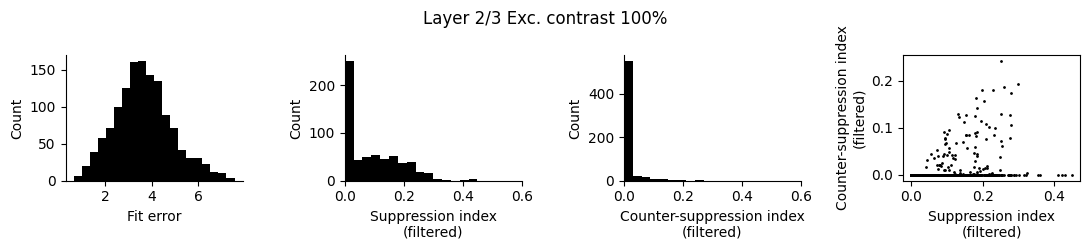

In [15]:
fig, axs = plt.subplots(1, 4, figsize=(11, 2.5))

axs[0].hist(errs, color="black", bins=20)
axs[0].spines['top'].set_visible(False)
axs[0].spines['right'].set_visible(False)
axs[0].set_xlabel("Fit error")
axs[0].set_ylabel("Count")

axs[1].hist(sis_filtered, color="black", range=(0., 0.6), bins=20)
axs[1].spines['top'].set_visible(False)
axs[1].spines['right'].set_visible(False)
axs[1].set_xlabel("Suppression index\n(filtered)")
axs[1].set_ylabel("Count")
axs[1].set_xlim(0, 0.6)

axs[2].hist(csis_filtered, color="black", range=(0., 0.6), bins=20)
axs[2].spines['top'].set_visible(False)
axs[2].spines['right'].set_visible(False)
axs[2].set_xlabel("Counter-suppression index\n(filtered)")
axs[2].set_ylabel("Count")
axs[2].set_xlim(0, 0.6)

axs[3].scatter(sis_filtered, csis_filtered, color="black", s=1)
axs[3].set_xlabel("Suppression index\n(filtered)")
axs[3].set_ylabel("Counter-suppression index\n(filtered)")

fig.suptitle(f"{sheet_names_formatted[sheet_name]} contrast 100%")

plt.tight_layout()

plt.savefig(f"./figures/size_tuning_{run_id}.png", dpi=100, bbox_inches="tight", transparent=True)
plt.show()

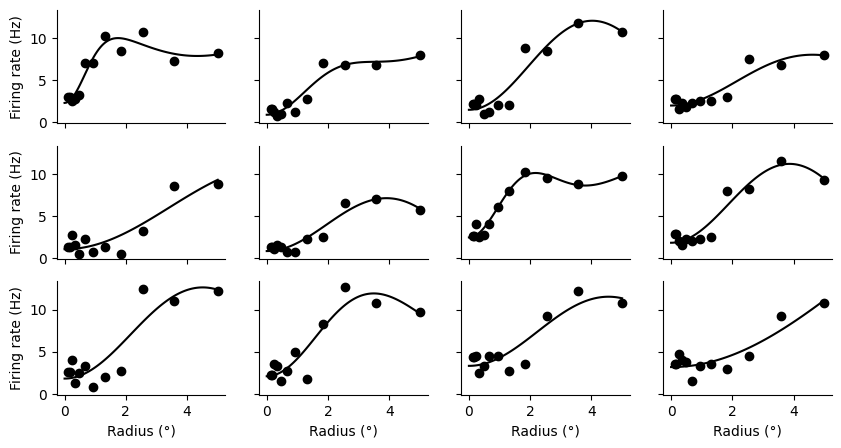

In [16]:
fig, axs = plt.subplots(3, 4, figsize=(10, 5), sharex=True, sharey=True)

for idx_cell, cell in enumerate(cells):

    if idx_cell > 11:
        break

    values = [cell.get_mean_rate_for_radius(radius) for radius in radiuses]
    rads = list(radiuses)

    rads, values = zip(*sorted(zip(rads,values)))
    rads = numpy.array(rads)
    values = numpy.array(values)

    res = differential_evolution(
        error_function_evo,
        bounds=[(0, 60), (0, 20), (0, 60), (0, 15), (0, 15), (0, 25), (0, 5)],
        args=(rads, values),
        strategy='rand2bin',
        maxiter=10000,
        popsize=30,
        tol=0.1,
        mutation=(0.5, 1.5),
        recombination=0.95,
        workers=1,
    )

    X_fit = numpy.linspace(0, 5, 100)
    Y_fit = sum_of_gaussian(res.x, X_fit)

    ax = axs[idx_cell % 3, idx_cell // 3]
    ax.scatter(rads, values, color="black")
    ax.plot(X_fit, Y_fit, color="black")

for ax in axs.flatten():
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
for col in range(3):
    axs[col, 0].set_ylabel("Firing rate (Hz)")
for row in range(4):
    axs[-1, row].set_xlabel("Radius (°)")

plt.savefig(f"./figures/fit_size_tuning_{run_id}.png", dpi=100, bbox_inches="tight", transparent=True)
plt.show()